# Construyendo una red neuronal con *PyTorch*

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

## Cargando los datos del CIFAR10

- El conjunto de datos a utilizar es el **[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)**.
- Es un conjunto estándar para hacer *reconocimiento de imágenes*.
- Buscamos entrenar un clasificador que reconozca que está siendo mostrado en la imagen de un conjunto fijo de categorías posibles.
- El *CIFAR10* está compuesto por imágenes a color de *32x32* píxeles representadas como tensores de *32x32x3*, donde la tercera dimensión representa el *channel* (i.e. el color en **RGB**). Los valores representan la intensidad de cada color en dicho pixel.
- La salida son 10 clases: avión, auto, pájaro, gato, siervo, perro, sapo, caballo, bote, camión.
- La librería `torchvision` nos facilita obtener el conjunto de datos.

In [2]:
CIFAR_CLASSES = ('plane',
                 'car',
                 'bird',
                 'cat',
                 'deer', 
                 'dog',
                 'frog',
                 'horse',
                 'ship',
                 'truck')

BATCH_SIZE = 128 # For mini-batch gradient descent.

# This is to normalize from PILImage to Torch Tensors in range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Explorando el CIFAR10

Vamos a explorar algunas de las imágenes que muestra el conjunto de datos del CIFAR10.

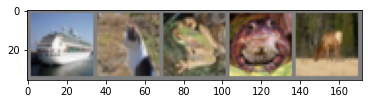

ship | cat | frog | frog | deer


In [3]:
def imshow(img):
    img = img / 2 + 0.5 # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener algunas imágenes de entrenamiento
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images[:5], labels[:5]

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' | '.join(CIFAR_CLASSES[l] for l in labels))

## Arquitectura de la Red Neuronal

Las primeras decisiones a la hora de construir un modelo neuronal son la cantidad de capas, la cantidad y el tipo de neuronas en cada capa, y las conexiones entre capas.

Comenzaremos por construir el modelo más básico posible: un *perceptrón multicapa* o **MLP**. Se compone de *N* capas lineares, seguidas de una activación no lineal. En la capa linear, cada neurona se conecta con todas las neuronas de la capa anterior (por eso se llaman *fully connected*).

La forma más rápida de implementar el modelo es utilizando los siguientes objetos de *Torch*:

- La capa lineal *fully connected* se construye con [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).
    - Internamente tiene dos tensores, una matriz de pesos y un vector de biases. *PyTorch* nos abstrae de eso.
    - Es equivalente a la capa [`Dense`](https://keras.io/api/layers/core_layers/dense/) en [Keras](https://keras.io/).
- La función de activación *relu* se construye con [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), que aplica una transformación *relu* a todas las neuronas de la capa anterior.
- Las capas se conectan entre sí con el modelo [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). Es un modelo donde cada capa recibe como entrada la salida de la capa anterior.
    - Es limitado en sus usos posibles, pero tiene la ventaja de abstraer completamente el funcionamiento.
    - Es equivalente al modelo [`tf.keras.Sequential`](https://keras.io/api/models/sequential/#sequential-class) de [Keras](https://keras.io/).

```python
model = nn.Sequential(
    nn.Linear(32 * 32 * 3, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)
```

### Modelo de *PyTorch*

En esta materia vamos a utilizar el paradigma funcional de *PyTorch* para construir nuestras redes, ya que permite un grado de personalización mucho más profundo.

Los modelos en *PyTorch* heredan de la clase [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). La clase posee dos métodos que requieren definirse:
- `__init__` Define la estructura de la red (i.e las capas que posee).
- `forward` Define como interactúan las capas de la red (i.e. las operaciones que se realizan sobre los tensores).

In [4]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(32 * 32 * 3, 1024)
        self.hidden_layer2 = nn.Linear(1024, 512)
        self.output_layer = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor):
        x = self.hidden_layer1(x) # Go through hidden layer1
        x = F.relu(x) # Activation Function
        x = self.hidden_layer2(x) # Go through hidden layer2
        x = F.relu(x) # Activation Function
        x = self.output_layer(x)  # Output Layer
        return x

model = MLP()

Podemos inspeccionar el modelo simplemente imprimiéndolo.

In [5]:
print(model)

MLP(
  (hidden_layer1): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=10, bias=True)
)


Es posible observar que nos devuelve el modelo inicializado al azar (notar que no se requiere reordenar la matriz que representa la imagen):

In [6]:
img_check, label_check = dataiter.next()
img_check, label_check = img_check[0], label_check[0]

print(f'Clase Real: {CIFAR_CLASSES[label_check]}')
print(f'Clase Devuelta: {CIFAR_CLASSES[model(img_check.view(-1)).argmax().item()]}')

Clase Real: dog
Clase Devuelta: plane


## Preparando el modelo para entrenamiento

- Para minimizar una red neuronal necesitamos *calcular sus gradientes*. Esto se hace con el algoritmo de *retropropagación*.
- *PyTorch* tiene la capacidad de hacerlo automáticamente. Esto se conoce como _diferenciación automática_ y es algo común en los frameworks de deep learning.
- Necesitaremos definir dos componentes para entrenar un modelo: la **función de costo** y el **algoritmo de optimización**.

### Función de costo

- La función de costo puede cambiar de acuerdo al tipo de problema (clasificación binaria/multiclase o regresión).
    - Las funciones más comunes son la media del error cuadrático (_mean squared error_) para regresión y la entropía cruzada (_crossentropy_) para clasificación.
    - Las funciones de costo necesitan ser diferenciables, las más comunes ya están implementadas (con sus respectivas derivadas) en *PyTorch*.

### Algoritmo de optimización

- El algoritmo de optimización es el que entrena la red. Existen varios, que en sí son variaciones del algoritmo de _descenso por gradiente_.
    - El módulo [`torch.optim`](https://pytorch.org/docs/stable/optim.html) tiene implementados varios algoritmos de optimización muy utilizados en aprendizaje automático.

<div style='text-align: center; margin: 5px 0;'>
    <div style='display: inline-block;'>
        <img src='images/1_Contours_Evaluation.gif' alt='Optimización' width='350px;'/>
    </div>
    <div style='display: inline-block;'>
        <img src='images/1_SaddlePoint_Evaluation.gif' alt='Optimización' width='350px;'/>
    </div>
</div>
<div style='text-align:right;font-size:0.75em;'>
    Fuente:
    <a href='http://ruder.io/optimizing-gradient-descent/' target='_blank'>
        http://ruder.io/optimizing-gradient-descent/
    </a>
</div>

In [7]:
model = MLP()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Entrenamiento

Ya teniendo todos los parámetros definidos, el modelo está listo para entrenarse.

*PyTorch* no provee una solución *out-of-the-box* para el bucle de entrenamiento (o en inglés *training loop*), a diferencia de *scikit-learn* y *Keras* que proveen `fit` y `predict`. Existen algunas librerías que proveen dicha abstracción, pero dejamos como ejercicio [buscar alguna](https://pytorch.org/ecosystem/) si lo consideran necesario. En general si bien el hecho de tener que hacer el loop de entrenamiento desde cero es un poco tedioso, da lugar a mucha más personalización y control del proceso de entrenamiento.

In [8]:
EPOCHS = 5

model.train() # Tell the model to set itself to 'train' mode.
for epoch in range(EPOCHS): # Loop over the dataset multiple times.
    running_loss = 0.0
    pbar = tqdm(trainloader)
    for i, (inputs, labels) in enumerate(pbar, 1):
        # Zero the parameter gradients.
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.view(inputs.shape[0], -1))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics.
        running_loss += loss.item()
        if i % 100 == 0: # Print every 100 mini-batches.
            pbar.set_description(f'[{epoch + 1}, {i}] loss: {running_loss / 100:.3g}')
            running_loss = 0.0

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

### Guardar el modelo

Para guardar los parámetros del modelo entrenado:
```python
torch.save(model.state_dict(), 'data/cifar-model.pth')
```

Para recuperar los pesos del modelo:

```python
  model = MLP()
  model.load_state_dict(torch.load('data/cifar-model.pth'))
  model.eval(); # Activate evaluation mode.
```

## Evaluación

### Evaluación Manual

Podemos ver como funciona el modelo luego de un ciclo de entrenamiento. Primero seleccionamos un conjunto de imágenes para predecir...

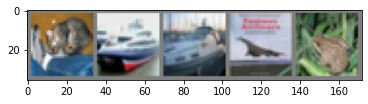

GroundTruth: cat | ship | ship | plane | frog


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images[:5], labels[:5]

# Print images!
imshow(torchvision.utils.make_grid(images))
print(f'GroundTruth: {" | ".join(CIFAR_CLASSES[l] for l in labels)}')

Aplicamos el modelo a las imágenes seleccionadas. Es *muy importante* cambiar el modo del modelo a evaluación.

In [10]:
model.eval(); # Activate evaluation mode.

In [11]:
# Remember to flatten the 2D images to a single long tensor with `view`.
outputs = model(images.view(images.shape[0], -1))
_, predicted = torch.max(outputs, 1)

print(f'Predicted: {" | ".join(CIFAR_CLASSES[p] for p in predicted)}')

Predicted: cat | ship | ship | ship | deer


### Evaluación General

Si queremos medir que tan bien está funcionando en general, necesitamos correr la evaluación para todos los valores de test...

In [12]:
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(testloader):
        outputs = model(inputs.view(inputs.shape[0], -1))
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

print(classification_report(y_true, y_pred, target_names=CIFAR_CLASSES))

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       plane       0.51      0.48      0.50      1000
         car       0.48      0.51      0.50      1000
        bird       0.37      0.21      0.27      1000
         cat       0.33      0.27      0.30      1000
        deer       0.38      0.37      0.38      1000
         dog       0.40      0.33      0.36      1000
        frog       0.41      0.57      0.48      1000
       horse       0.44      0.49      0.46      1000
        ship       0.52      0.58      0.55      1000
       truck       0.46      0.53      0.49      1000

    accuracy                           0.44     10000
   macro avg       0.43      0.44      0.43     10000
weighted avg       0.43      0.44      0.43     10000



## Entrenamiento en GPU

El entrenamiento en GPU requiere que enviemos el modelo y los datos al GPU. Para ello, se deben cambiar algunas cosas.

### Definir el dispositivo

Primero se define el dispositivo a utilizar. Si se dispone de GPU, la aprovechamos, en caso contrario se selecciona el CPU.

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Una vez seleccionado el dispositivo, debemos crear y enviar el modelo a dicho dispositivo.

In [14]:
model = MLP()
model.to(device)

# We need to define the loss function and optimizer again!
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

De aquí en adelante los pasos son prácticamente los mismos que para el [entrenamiento](#Entrenamiento). Es importante que definamos nuevamente el algoritmo de optimización sobre los parámetros nuevos que en este caso se enviaron al GPU. Luego, durante el *training loop* debemos asegurarnos de, previo a pasar los datos al modelo, estos sean cargados en el dispositivo:

In [15]:
model.train() # Tell the model to set itself to 'train' mode.
for epoch in range(EPOCHS): # Loop over the dataset multiple times.
    running_loss = 0.0
    pbar = tqdm(trainloader)
    for i, (inputs, labels) in enumerate(pbar, 1):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Run the rest of the algorithm as usual.

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.view(inputs.shape[0], -1))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics.
        running_loss += loss.item()
        if i % 100 == 0: # Print every 100 mini-batches.
            pbar.set_description(f'[{epoch + 1}, {i}] loss: {running_loss / 100:.3g}')
            running_loss = 0.0

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

In [16]:
model.eval(); # Activate evaluation mode.

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Run the rest of the algorithm as usual.

        outputs = model(inputs.view(inputs.shape[0], -1))
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=CIFAR_CLASSES))

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       plane       0.51      0.53      0.52      1000
         car       0.47      0.55      0.51      1000
        bird       0.35      0.29      0.32      1000
         cat       0.34      0.30      0.32      1000
        deer       0.40      0.28      0.33      1000
         dog       0.40      0.36      0.38      1000
        frog       0.43      0.56      0.48      1000
       horse       0.46      0.46      0.46      1000
        ship       0.55      0.54      0.55      1000
       truck       0.45      0.53      0.49      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.43     10000
weighted avg       0.44      0.44      0.43     10000

